In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import tensorflow as tf

In [3]:
directory= '/content/drive/MyDrive/FightOS/data/train'

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import os
import pandas as pd

In [5]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=True,
    crop_to_aspect_ratio=False,
)

Found 1923 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


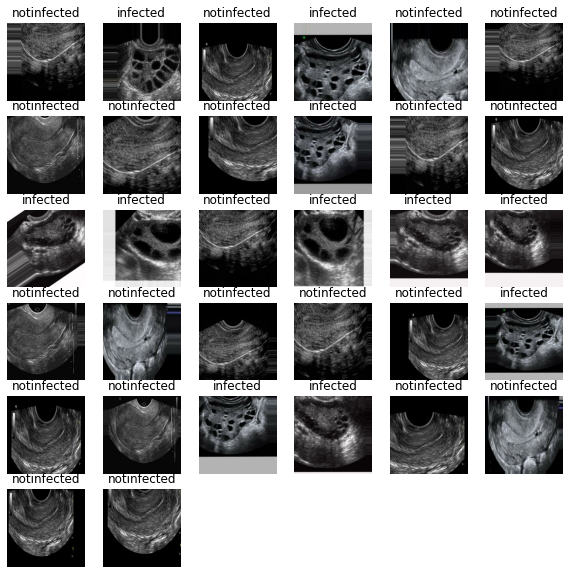

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

RGB TO Gray

In [7]:
gray_directory_train= '/content/drive/MyDrive/FightOS/graydata/train'

In [8]:
import cv2
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
#/content/blnw-images-224/bolt/00_09_0101_0100_0400_10.png
def load_images_from_folder(folder,direc,ext=["jpg","png","jpeg"]):
    # images = []
    for filename in os.listdir(folder):
      file_ext = filename.split(".")
      if len(file_ext) ==2 and file_ext[1] in ext:
        grey_img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        # save image
        status = cv2.imwrite(direc+filename,grey_img)
    return 

In [9]:
load_images_from_folder(directory+'/infected',gray_directory_train+'/infected/')

In [ ]:
load_images_from_folder(directory+'/notinfected',gray_directory_train+'/notinfected/')

Augumentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3,
                             fill_mode='nearest'
                             )
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( gray_directory_train, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='training',
                                       seed=24)
# prepare an iterators for each dataset
val_it = datagen.flow_from_directory( gray_directory_train, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='validation',
                                       seed=24)

Found 1347 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [ ]:
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(100, 2), min=0.000, max=1.000
Batch shape=(100, 224, 224, 3), min=0.000, max=1.000


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential

# Model 1

In [ ]:
model1 = Sequential()
model1.add(Conv2D(10, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES
model1.add(Conv2D(12, (5,5),padding='valid',activation='relu'))
model1.add(MaxPooling2D(pool_size=(4,4)))
#model1.add(Conv2D(128, (5,5),padding='valid',activation='relu'))
# model1.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model1.add(MaxPooling2D(pool_size=(4,4)))
model1.add(Flatten())
#model1.add(Dense(128,activation='relu'))
#model1.add(Dense(64,activation='relu'))
model1.add(Dense(2,activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 10)      760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 12)        3012      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 12)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 2)                 3

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model1.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model1.fit( 
  train_it,
  validation_data=val_it,
  epochs=5)

Epoch 1/5
14/14 [==============================] - 43s 2s/step - loss: 0.5673 - accuracy: 0.7765 - val_loss: 0.4154 - val_accuracy: 0.8385
Epoch 2/5
14/14 [==============================] - 33s 2s/step - loss: 0.3284 - accuracy: 0.8679 - val_loss: 0.2509 - val_accuracy: 0.9010
Epoch 3/5
14/14 [==============================] - 33s 2s/step - loss: 0.2234 - accuracy: 0.9094 - val_loss: 0.1598 - val_accuracy: 0.9306
Epoch 4/5
14/14 [==============================] - 33s 2s/step - loss: 0.1292 - accuracy: 0.9555 - val_loss: 0.0933 - val_accuracy: 0.9722
Epoch 5/5
14/14 [==============================] - 33s 2s/step - loss: 0.0830 - accuracy: 0.9777 - val_loss: 0.0538 - val_accuracy: 0.9844


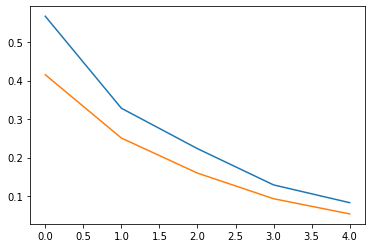

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Model 2 

final model

In [ ]:
model2 = Sequential()
model2.add(Conv2D(12, (6,6),padding='valid',activation='relu',input_shape=(224,224,3)))
model2.add(MaxPooling2D(pool_size=(6,6)))
model2.add(Conv2D(15, (5,5),padding='valid',activation='relu'))
model2.add(MaxPooling2D(pool_size=(5,5)))
model2.add(Conv2D(10, (3,3),padding='valid',activation='relu'))
# model2.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
model2.add(MaxPooling2D(pool_size=(3,3)))
model2.add(Flatten())
#model2.add(Dense(128,activation='relu'))
#model2.add(Dense(64,activation='relu'))
model2.add(Dense(2,activation='softmax'))

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model2.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model2.fit( 
  train_it,
  validation_data=val_it,
  epochs=8)

Epoch 1/8
14/14 [==============================] - 36s 3s/step - loss: 0.6649 - accuracy: 0.6147 - val_loss: 0.6354 - val_accuracy: 0.6840
Epoch 2/8
14/14 [==============================] - 33s 2s/step - loss: 0.5906 - accuracy: 0.7283 - val_loss: 0.5252 - val_accuracy: 0.7240
Epoch 3/8
14/14 [==============================] - 33s 2s/step - loss: 0.4506 - accuracy: 0.8330 - val_loss: 0.3555 - val_accuracy: 0.8542
Epoch 4/8
14/14 [==============================] - 33s 2s/step - loss: 0.2817 - accuracy: 0.9317 - val_loss: 0.1958 - val_accuracy: 0.9514
Epoch 5/8
14/14 [==============================] - 33s 2s/step - loss: 0.1688 - accuracy: 0.9636 - val_loss: 0.1247 - val_accuracy: 0.9653
Epoch 6/8
14/14 [==============================] - 33s 2s/step - loss: 0.1194 - accuracy: 0.9621 - val_loss: 0.0924 - val_accuracy: 0.9792
Epoch 7/8
14/14 [==============================] - 33s 2s/step - loss: 0.0859 - accuracy: 0.9733 - val_loss: 0.0719 - val_accuracy: 0.9809
Epoch 8/8
14/14 [==========

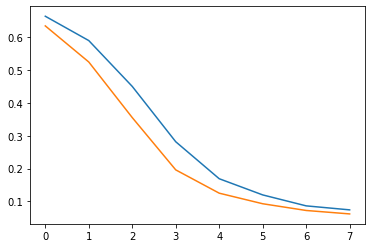

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#Model 3


In [ ]:
model3 = Sequential()
model3.add(Conv2D(10, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model3.add(MaxPooling2D(pool_size=(4,4)))
model3.add(Conv2D(12, (5,5),padding='valid',activation='relu'))
model3.add(MaxPooling2D(pool_size=(4,4)))
model3.add(Conv2D(5, (3,3),padding='valid',activation='relu'))
# model3.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
model3.add(MaxPooling2D(pool_size=(3,3)))
model3.add(Flatten())
#model3.add(Dense(128,activation='relu'))
#model3.add(Dense(64,activation='relu'))
model3.add(Dense(2,activation='softmax'))

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model3.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model3.fit( 
  train_it,
  validation_data=val_it,
  epochs=6)

Epoch 1/6
14/14 [==============================] - 36s 3s/step - loss: 0.6757 - accuracy: 0.5939 - val_loss: 0.6700 - val_accuracy: 0.5938
Epoch 2/6
14/14 [==============================] - 33s 2s/step - loss: 0.6570 - accuracy: 0.5939 - val_loss: 0.6425 - val_accuracy: 0.5938
Epoch 3/6
14/14 [==============================] - 33s 2s/step - loss: 0.6251 - accuracy: 0.5991 - val_loss: 0.5926 - val_accuracy: 0.6632
Epoch 4/6
14/14 [==============================] - 33s 2s/step - loss: 0.5382 - accuracy: 0.7595 - val_loss: 0.4436 - val_accuracy: 0.8646
Epoch 5/6
14/14 [==============================] - 32s 2s/step - loss: 0.3586 - accuracy: 0.9102 - val_loss: 0.2515 - val_accuracy: 0.9358
Epoch 6/6
14/14 [==============================] - 33s 2s/step - loss: 0.1979 - accuracy: 0.9480 - val_loss: 0.1479 - val_accuracy: 0.9583


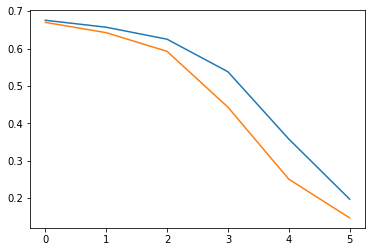

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Model 4

In [ ]:
model4 = Sequential()
model4.add(Conv2D(12, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model4.add(MaxPooling2D(pool_size=(4,4)))
model4.add(Conv2D(10, (5,5),padding='valid',activation='relu'))
model4.add(MaxPooling2D(pool_size=(4,4)))
model4.add(Conv2D(8, (3,3),padding='valid',activation='relu'))
# model4.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
model4.add(MaxPooling2D(pool_size=(3,3)))
model4.add(Flatten())
#model4.add(Dense(128,activation='relu'))
#model4.add(Dense(64,activation='relu'))
model4.add(Dense(2,activation='softmax'))

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model4.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model4.fit( 
  train_it,
  validation_data=val_it,
  epochs=10)

Epoch 1/10
14/14 [==============================] - 37s 3s/step - loss: 0.6875 - accuracy: 0.5538 - val_loss: 0.6374 - val_accuracy: 0.7622
Epoch 2/10
14/14 [==============================] - 33s 2s/step - loss: 0.5836 - accuracy: 0.7899 - val_loss: 0.5008 - val_accuracy: 0.8906
Epoch 3/10
14/14 [==============================] - 33s 2s/step - loss: 0.4069 - accuracy: 0.8946 - val_loss: 0.2984 - val_accuracy: 0.8976
Epoch 4/10
14/14 [==============================] - 33s 2s/step - loss: 0.2223 - accuracy: 0.9391 - val_loss: 0.1414 - val_accuracy: 0.9757
Epoch 5/10
14/14 [==============================] - 33s 2s/step - loss: 0.1190 - accuracy: 0.9673 - val_loss: 0.0981 - val_accuracy: 0.9670
Epoch 6/10
14/14 [==============================] - 33s 2s/step - loss: 0.0771 - accuracy: 0.9814 - val_loss: 0.0691 - val_accuracy: 0.9792
Epoch 7/10
14/14 [==============================] - 33s 2s/step - loss: 0.0766 - accuracy: 0.9792 - val_loss: 0.0514 - val_accuracy: 0.9913
Epoch 8/10
14/14 [==

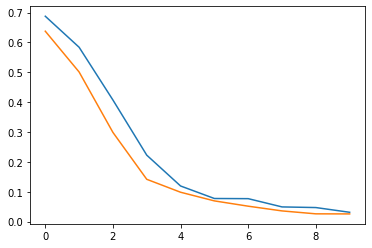

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Model 5

In [ ]:
model5 = Sequential()
model5.add(Conv2D(15, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model5.add(MaxPooling2D(pool_size=(5,5)))
model5.add(Conv2D(12, (4,4),padding='valid',activation='relu'))
model5.add(MaxPooling2D(pool_size=(4,4)))
model5.add(Conv2D(8, (3,3),padding='valid',activation='relu'))
# model5.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
model5.add(MaxPooling2D(pool_size=(3,3)))
model5.add(Flatten())
#model5.add(Dense(128,activation='relu'))
#model5.add(Dense(64,activation='relu'))
model5.add(Dense(2,activation='softmax'))

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model5.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model5.fit( 
  train_it,
  validation_data=val_it,
  epochs=7)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
#IMAGE_SIZE = [224, 224]

In [ ]:
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
#for layer in vgg.layers:
 # layer.trainable = False

In [ ]:
#output_classes = 2

In [ ]:
# our layers - you can add more if you want
#x = Flatten()(vgg.output)
#x = Dense(1000, activation='relu')(x)
# x = Dense(500, activation='relu')(x) 
#prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
#model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
#model.summary()

In [ ]:
# tell the model what cost and optimization method to use
#model.compile(
  #loss='binary_crossentropy',
  #optimizer='adam',
  #metrics=['accuracy']
#)

In [ ]:
#history_vgg= model.fit(
 # train_it,
 # validation_data=val_it,
  #epochs=5
#)

In [ ]:
#history_vgg.history.keys()

In [ ]:
#import matplotlib.pyplot as plt
#plt.plot(history_vgg.history['loss'])
#plt.plot(history_vgg.history['val_loss'])

In [ ]:
#plt.plot(history_vgg.history['accuracy'])
#plt.plot(history_vgg.history['val_accuracy'])

In [ ]:
#model.save_weights('model.h5')

Save Model Using pickle

In [ ]:
import pickle
pickle.dump(model2, open('model.pkl','wb'))



saving model using keras


In [ ]:
model2.save('/content/drive/MyDrive/FightOS/model.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/FightOS/model.h5')
#model.predict(X_test)

In [ ]:

from keras.preprocessing.image import load_img
image = load_img('/content/drive/MyDrive/FightOS/graydata/train/notinfected/img1.jpeg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
prediction = model.predict(img)

In [ ]:
type(prediction)

In [ ]:
print(prediction)

In [ ]:
l={"infected":prediction[0][0],"notinfected":prediction[0][1]}
def get_key(val):
    for key, value in l.items():
         if val == value:
             return key
 
    return "key doesn't exist"
#label[0][1]

In [ ]:
j=prediction.max()
get_key(j)